In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torchvision.models as models
from sklearn.metrics import f1_score
import torch.nn.functional as F
from tqdm import trange, tqdm
import torch.optim as optim
# Đọc file CSV thành DataFrame
df = pd.read_csv("filtered_labels.csv")
df.head()

,STT,TEXT,COUNT,VIDEOS
0,1,1,1,D0530.mp4
1,2,2,1,D0531.mp4
2,3,3,1,D0532.mp4
3,4,4,1,D0533.mp4
4,5,5,1,D0534.mp4


In [2]:
keypoints = None
labels = None
window_size = 15  # Kích thước cửa sổ
stride = 1  # Bước nhảy giữa các cửa sổ
for i, label, file_name in zip(df.index, df["TEXT"], df["VIDEOS"]):
    files = [x.strip() for x in file_name.split(",")]
    for file in files:
        file = file.split(".")[0]
        file_keypoints = f"data/Keypoints/{file}.npy"
        file_labels = f"data/Labels/{file}.npy"
        if os.path.exists(file_keypoints) and os.path.exists(file_labels):
            keypoint = np.load(file_keypoints)
            label = np.load(file_labels)
            if keypoints is None:
                keypoints = keypoint
                labels = label
            else:
                keypoints = np.concatenate((keypoints, keypoint), axis=0)
                labels = np.concatenate((labels, label), axis=0)
keypoints = torch.from_numpy(keypoints).float().view(-1, 75, 2)
keypoints = keypoints.unfold(dimension=0, size=window_size, step=stride)
labels = labels[window_size-1::stride]
labels = torch.from_numpy(labels).long()  
print(keypoints.shape, labels.shape)

torch.Size([3982, 75, 2, 15]) torch.Size([3982])


In [3]:
class JointSequenceResNet(nn.Module):
    """
    ResNet-based classifier for joint sequences.
    
    - Expects input coords: (N, V, 2, T), where
        N = batch size,
        T = num_frames (e.g., 15),
        V = num_joints  (e.g., 75),
        2 = (x, y).
    - Converts to 'image' of shape (N, 2, V, T) and feeds into ResNet-18.
    """
    def __init__(self, num_joints, num_frames, num_classes):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        # Modify first conv to accept 2 channels (x and y)
        self.backbone.conv1 = nn.Conv2d(
            in_channels=2,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        # Remove the initial maxpool for small 'images'
        self.backbone.maxpool = nn.Identity()
        # Replace classifier head
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, coords):
        """
        coords: Tensor of shape (N, T, V, 2)
        returns: logits (N, num_classes)
        """
        N, V, _, T = coords.shape
        x = coords.permute(0, 2, 1, 3).contiguous()
        logits = self.backbone(x)
        return logits

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    keypoints, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels   # <-- Đây chính là stratify
)
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)

# 2) Tạo DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,    # chỉ shuffle train
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,   # không shuffle val
    num_workers=4
)

In [5]:
lr = 1e-4
weight_decay = 1e-5
model = JointSequenceResNet(num_joints=75, num_frames=15, num_classes=51)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
class_weights = torch.ones(51, device=device)
class_weights[0] = 0.005
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


/home/na/anaconda3/envs/vslr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/na/anaconda3/envs/vslr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
num_epochs = 50
history = []
for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0
    train_true, train_pred = [], []
    for batch_coords, batch_labels in train_loader:
        batch_coords = batch_coords.to(device)   # (B,75,2,15)
        batch_labels = batch_labels.to(device)   # (B,)
        optimizer.zero_grad()

        outputs = model(batch_coords)            # (B,51)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_coords.size(0)
        _, preds = torch.max(outputs, 1)
        train_true.extend(batch_labels.cpu().numpy())
        train_pred.extend(preds.cpu().numpy())
    f1_train = f1_score(train_true, train_pred, average='macro')
    avg_train_loss = total_loss / len(train_loader.dataset)
    print(len(train_true), train_true)
    print(len(train_pred), train_pred)
    model.eval()
    val_loss_sum = 0.0
    val_true, val_pred = [], []
    with torch.no_grad():
        for batch_coords, batch_labels in val_loader:
            batch_coords = batch_coords.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_coords)
            val_loss = criterion(outputs, batch_labels)
            _, preds = torch.max(outputs, 1)
            val_loss_sum += val_loss.item() * batch_coords.size(0)
            val_true.extend(batch_labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
    avg_val_loss = val_loss_sum / len(val_loader.dataset)
    f1_val = f1_score(val_true, val_pred, average='macro')
    print(len(val_true), val_true)
    print(len(val_pred), val_pred)
    history.append({
        'epoch': epoch,
        'train_loss': avg_train_loss,
        'train_f1': f1_train,
        'val_loss': avg_val_loss,
        'val_f1': f1_val
    })

    print(f"Epoch {epoch:02d} — "
          f"Train Loss: {avg_train_loss:.4f}, Train F1: {f1_train:.4f} — "
          f"Val Loss: {avg_val_loss:.4f}, Val F1: {f1_val:.4f}")
# 5) Lưu mô hình
torch.save(model.state_dict(), 'resnet_keypoints_epoch20.pth')

3185 [0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 25, 0, 8, 0, 0, 0, 0, 0, 21, 0, 0, 0, 8, 0, 5, 0, 29, 0, 8, 0, 15, 28, 22, 0, 0, 0, 0, 10, 0, 0, 18, 0, 0, 0, 35, 0, 0, 10, 0, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 9, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 31, 25, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 37, 25, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 32, 0, 35, 0, 0, 21, 0, 2, 0, 0, 42, 0, 0, 3, 0, 0, 0, 40, 41, 0, 0, 0, 0, 0, 0, 20, 0, 29, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 5, 2, 0, 19, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 2, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 1, 0, 0, 34, 0, 0, 0, 32, 27, 0, 0, 0, 0, 0, 32, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 43, 0, 0, 9, 0, 0, 42, 0, 0, 0, 0, 0, 0, 20, 41, 0, 39, 0, 0, 33, 0, 0, 16, 44, 42, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0,

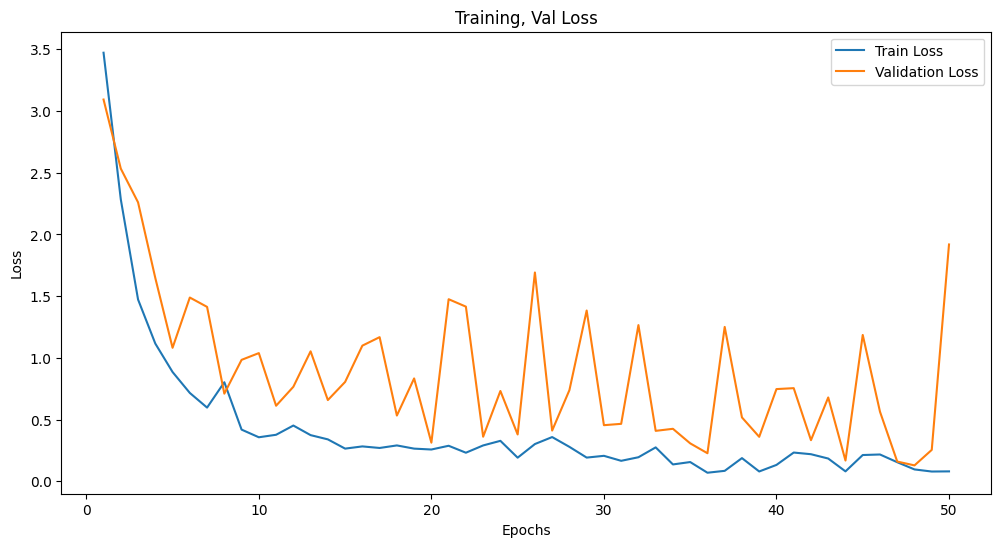

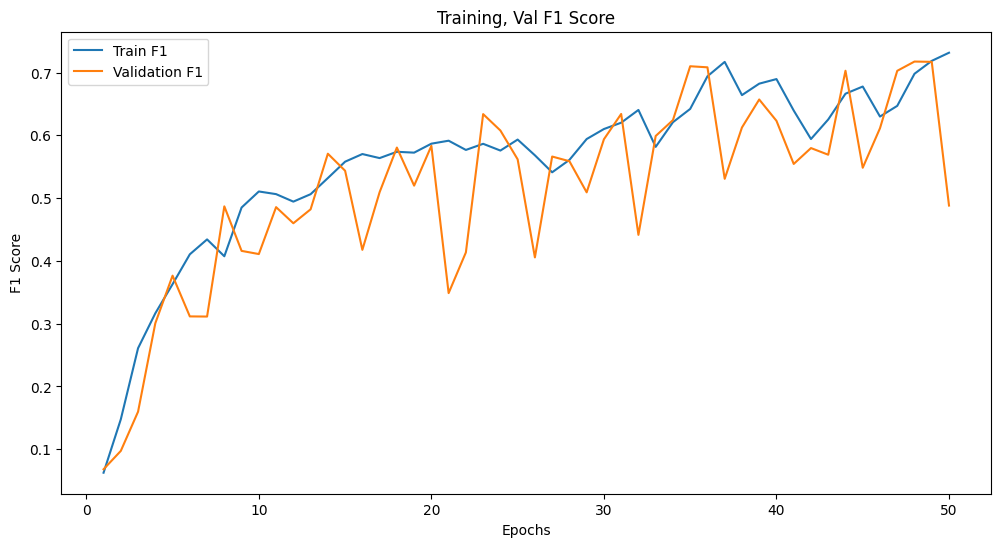

In [7]:
import matplotlib.pyplot as plt
#show history train and val loss
df = pd.DataFrame(history)
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Val Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['train_f1'], label='Train F1')
plt.plot(df['epoch'], df['val_f1'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training, Val F1 Score')
plt.legend()
plt.show()

In [8]:
def load_model(model_path: str, num_joints: int, num_frames: int, num_classes: int, device: str = 'cpu'):
    """
    Load the trained JointSequenceResNet model from checkpoint.
    """
    model = JointSequenceResNet(num_joints=num_joints,
                                num_frames=num_frames,
                                num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [9]:
def inference(model: nn.Module,
              seq_tensor: torch.Tensor,
              device: str = 'cpu') -> list:
    """
    Run inference on one or more keypoint sequences.

    Args:
        model: Trained JointSequenceResNet in eval() mode.
        seq_tensor: Tensor of shape (N, T, V, 2) with float coords.
        device: 'cpu' or 'cuda'.

    Returns:
        List of N predicted class indices.
    """
    model.to(device)
    model.eval()
    with torch.no_grad():
        seq_tensor = seq_tensor.to(device)
        outputs = model(seq_tensor)           
        preds = outputs.argmax(dim=1).cpu().tolist()
    return preds

In [10]:
import mediapipe as mp
from config import Config
from detector import MediaPipeProcessor

pose = MediaPipeProcessor(Config())
pose = mp.solutions.holistic.Holistic(
        static_image_mode=False,
        model_complexity=1,
        smooth_landmarks=True,
        enable_segmentation=False,
        refine_face_landmarks=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )
results = []

2025-06-30 20:00:41.649486: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 20:00:41.662153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751288441.684167   22697 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751288441.694220   22697 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-30 20:00:41.727121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [11]:
from collections import deque

def process_video(video_path, model, device, window_size=15):
    pose = MediaPipeProcessor(Config())
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video {video_path}")
    orig_fps = cap.get(cv2.CAP_PROP_FPS) or 6
    frame_interval = max(int(orig_fps // 6), 1)
    results = []
    frame_count = 0
    window = deque(maxlen=window_size)  # Use deque for efficient window management
    for _ in range(window_size):
        window.append(np.zeros((75, 2), dtype=np.float32))
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        # if frame_count % frame_interval != 0:
        #     continue
        # Process frame
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        _, result = pose.process_frame(rgb)
        frame_keypoints = pose.extract_keypoints(result)
        window.append(frame_keypoints)
        seq = np.stack(window, axis=0).astype(np.float32)  # (T, 75, 2)
        seq = torch.from_numpy(seq).unsqueeze(0).to(device)  # (1, T, 75, 2)
        seq = seq.permute(0, 2, 3, 1).contiguous()
        # Prepare input tensor: (1, 2, V, T)
        # Inference
        with torch.no_grad():
            logits = model(seq)            # (1, num_classes)
            pred = logits.argmax(dim=1).item()    # scalar
        results.append(pred)

    cap.release()
    return results

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model("resnet_keypoints_epoch20.pth",
                    num_joints=150,
                    num_frames=15,
                    num_classes=51,
                    device=device)


/home/na/anaconda3/envs/vslr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/na/anaconda3/envs/vslr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
path = "data/datatest"
video_files = [f for f in os.listdir(path) if f.endswith('.mp4')]
for video_file in video_files:
    video_path = os.path.join(path, video_file)
    print(f"Processing video: {video_path}")
    results = process_video(video_path, model, device, 15)
    print(f"Results for {video_file}: {results}")

Processing video: data/datatest/bộ đội.mp4
Results for bộ đội.mp4: [0, 0, 0, 41, 41, 41, 41, 41, 41, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]
Processing video: data/datatest/thương yêu.mp4
Results for thương yêu.mp4: [0, 0, 0, 41, 41, 41, 41, 41, 41, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39

KeyboardInterrupt: 